In [1]:
"""
    clustering.ipynb
    Functions for implementing k-means clustering for quantizing the colors in an image.
    Mustafa Siddiqui
"""
pass

In [3]:
from inc import IP
%matplotlib inline

In [146]:
def quantizeColors(img, numColors):
    ''' Quantize image into given number of colors using k-means 
        clustering algorithm.
    '''
    
    #red = img[:, :, 0].flatten()
    #blue = img[:, :, 1].flatten()
    #green = img[:, :, 2].flatten()
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    
    return red, green, blue

In [147]:
I = IP.imread('Doyley.jpg')
IGray = IP.rgb2gray(I);
l, w = IGray.shape

In [148]:
r, g, b = quantizeColors(I, 3)
#r = IP.np.reshape(r, (l, w))
#g = IP.np.reshape(g, (l, w))
#b = IP.np.reshape(b, (l, w))

In [149]:
out = IP.np.zeros((l, w, 3), dtype='int')
out[:,:,0] = r
out[:,:,1] = g
out[:,:,2] = b

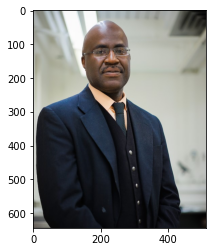

In [150]:
IP.imshow(out)

(644, 512, 3)

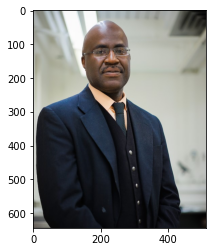

In [151]:
I2 = IP.imread('Doyley.jpg')
IP.imshow(I2)
I2.shape

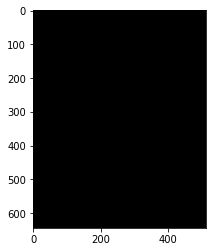

In [152]:
IP.imshow(I2-out, cmap='gray')